import os
os.chdir('./02-signal_testing')# readme
分析資料種包含的各種形態瑕疵

In [9]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.svm import SVR

In [10]:
from utils import xgb_model, get_data, lr_curve, eva_metric, xgb_grid_test, svm_grid_test
from noising import sig_disturb, sig_transmittion_noise, sig_drop, plt_drop

In [11]:
save_path = '03-signal_analysis'
package_path = 'water_MLOps'

In [12]:
import os
cwd = os.getcwd().split("/")[-1]
if cwd == package_path:
    print(cwd)
    if not os.path.isdir(save_path):
#         print('create '+save_path)
        os.mkdir(save_path)
    
if cwd == save_path:
    print('ok')
    pass
else:
    os.chdir(save_path)
os.getcwd()

ok


'/home/jovyan/git/water_MLOps/03-signal_analysis'

# EDA

In [57]:
df, label = get_data('~/git/water_MLOps/Cost-B.xlsx')
print(label.head())
df.head()

0    70.0
1    70.0
2    70.0
3    71.0
4    71.0
Name: dirt, dtype: float64


,C,D,time
0,17.000000,118.000000,0
1,114.680482,171.433735,1
2,287.000000,208.000000,2
3,17.000000,118.000000,3
4,123.428571,184.785714,4


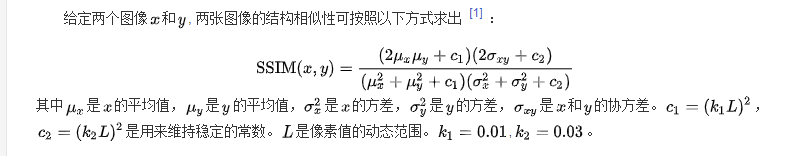

In [14]:
import numpy as np

def SSIM(x, y, k1=0.01, k2=0.03, paraL=None):
    k1 = k1
    k2 = k2
    covxy = np.cov(x, y)
    meanx = np.mean(x)
    stdx = np.std(x)

    meany = np.mean(y)
    stdy = np.std(y)

    mu1_sq = meanx ** 2
    mu2_sq = meany ** 2
    mu1_mu2 = meanx * meany
    sigma12 = covxy
    sigma1_sq = stdx ** 2 
    sigma2_sq = stdy ** 2 
    if paraL:
        L = paraL
    else:
        L = max(max(x), max(y))

    C1 = (k1*L)**2
    C2 = (k2*L)**2
    ssim =  ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                                (sigma1_sq + sigma2_sq + C2))
    ssim = np.mean(ssim)
    return(ssim)

In [15]:
x = [-2.1, -1,  4.3]
y = [3,  1.1,  0.12]

SSIM(x, y)

0.15125302536867996

### 鄰居overlap

In [21]:
# over lap
import numpy as np
def split_series(col, split, overlap=0.3):
    print('>> split_series')
    split = split
    lis = []
    split_index = []
    overlap = overlap
    size = int(np.floor((len(col)//split)*(1+overlap)))
    print('size = ', size)
    for i in range(split):
        a = i*len(col)//split
        b = a + size
        split_index.append(str(a)+str(b))
#         print(a,b)
        if b <= len(col):
            lis.append(col[a:b].values)
        else:
            pass
    print('>> split_series end')
    return lis, split_index


### 計算鄰居的SSIM

>> split_series
size =  22
>> split_series end


,key,score
0,0-1,0.374102
1,1-2,0.566694
2,2-3,0.355725
3,3-4,0.340298
4,4-5,0.545681


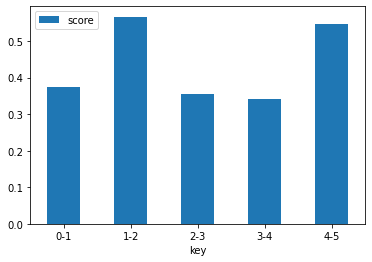

In [49]:
# neighbor
col = df.loc[:,'C']
target, _ = split_series(col, 7, 0.3)

tmp = pd.DataFrame(columns = ['key', 'score'])
for i in range(len(target)-1):
#     for _ in range()
#     print(i)
    a = target[i]

    b = target[i+1]
#     print(i, i+1)
    group = str(i)+'-'+str(i+1)
    score = SSIM(a, b)
    tmp.at[i, 'key'] = group
    tmp.at[i, 'score'] = score
#     print(score)
#     print('----')
#     a = SSIM(target[i], target[i+1], 0.01, 0.03)
#     print(a)
tmp.plot.bar(x='key', y = 'score', rot=0)
tmp

### 計算所有區塊相互的SSIM

>> split_series
size =  22
>> split_series end


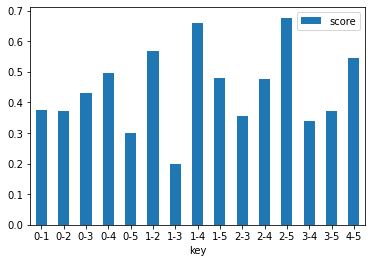

In [82]:
# all
df, label = get_data('~/git/water_MLOps/Cost-B.xlsx')
col = df.loc[:,'C']

target, _ = split_series(col, 7, 0.3)
tmp = pd.DataFrame(columns = ['key', 'score'])

lis_key = []
lis_score = []
    
for i in range(len(target)):

    a = target[i]
   

    for _ in range(i+1, len(target)):
        b = target[_]
#         print(i, _)
        score = SSIM(a, b)
        
        lis_key.append(str(i)+'-'+str(_))
        lis_score.append(score)

#     print('----')
#     a = SSIM(target[i], target[i+1], 0.01, 0.03)
#     print(a)
tmp['key'] = lis_key
tmp['score'] = lis_score
tmp.plot.bar(x='key', y = 'score', rot=0)
# tmp

## model test

In [83]:
def xgb_simple_test(df, label):
    
    X_train, X_test, y_train, y_test = train_test_split(df, label,
                                                        test_size=0.33, random_state=42)

    max_score = 0

    
    # model training 
    model = xgb_model(200, 'reg:squarederror', 'gbtree', 8) # epochs, objective, booster, max_depth
    model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_metric='mae', verbose = False)

    # model predict and evaulate.
    y_pred = model.predict(X_test)
    y_true = y_test
    


    return eva_metric(y_true, y_pred)

In [84]:
df, label = get_data('~/git/water_MLOps/Cost-B.xlsx')

# test on xgb
ans = xgb_simple_test(df, label)
# # test on svm
# svm_lis = svm_grid_test(df, label)

# save to csv
ans

{'mse': 0.3493604175378809,
 'mae': 0.36226608276366185,
 'r2_score': 0.9945135662752155}